In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

In [2]:
train_dir = '../input/fer2013-custom/fer2013custom/train/'
test_dir = '../input/fer2013-custom/fer2013custom/test/'

row, col = 48, 48
classes = 4

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  neutral   sad  happy
train   3995     4965  4830   7215
      angry  neutral   sad  happy
test    958     1233  1247   1774


PLot of number of images in training set


<AxesSubplot:>

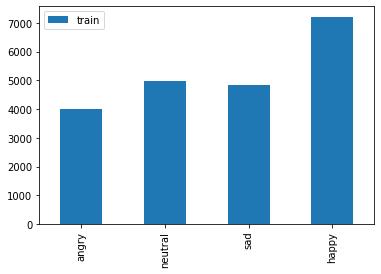

In [3]:
train_count.transpose().plot(kind='bar')

PLot of number of images in test set


<AxesSubplot:>

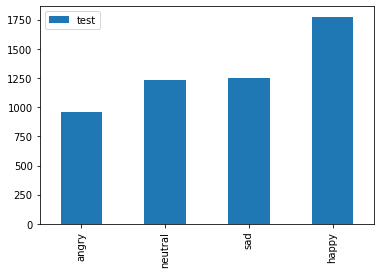

In [4]:
test_count.transpose().plot(kind='bar')

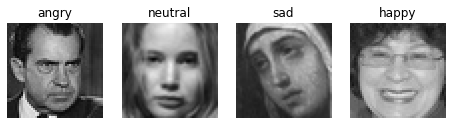

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [7]:
training_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

Defining Model

In [8]:
def get_model(input_size, classes=4):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

2022-01-31 19:25:13.257374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

2022-01-31 19:25:13.349815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:25:13.350540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:25:13.351599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 19:25:13.352530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

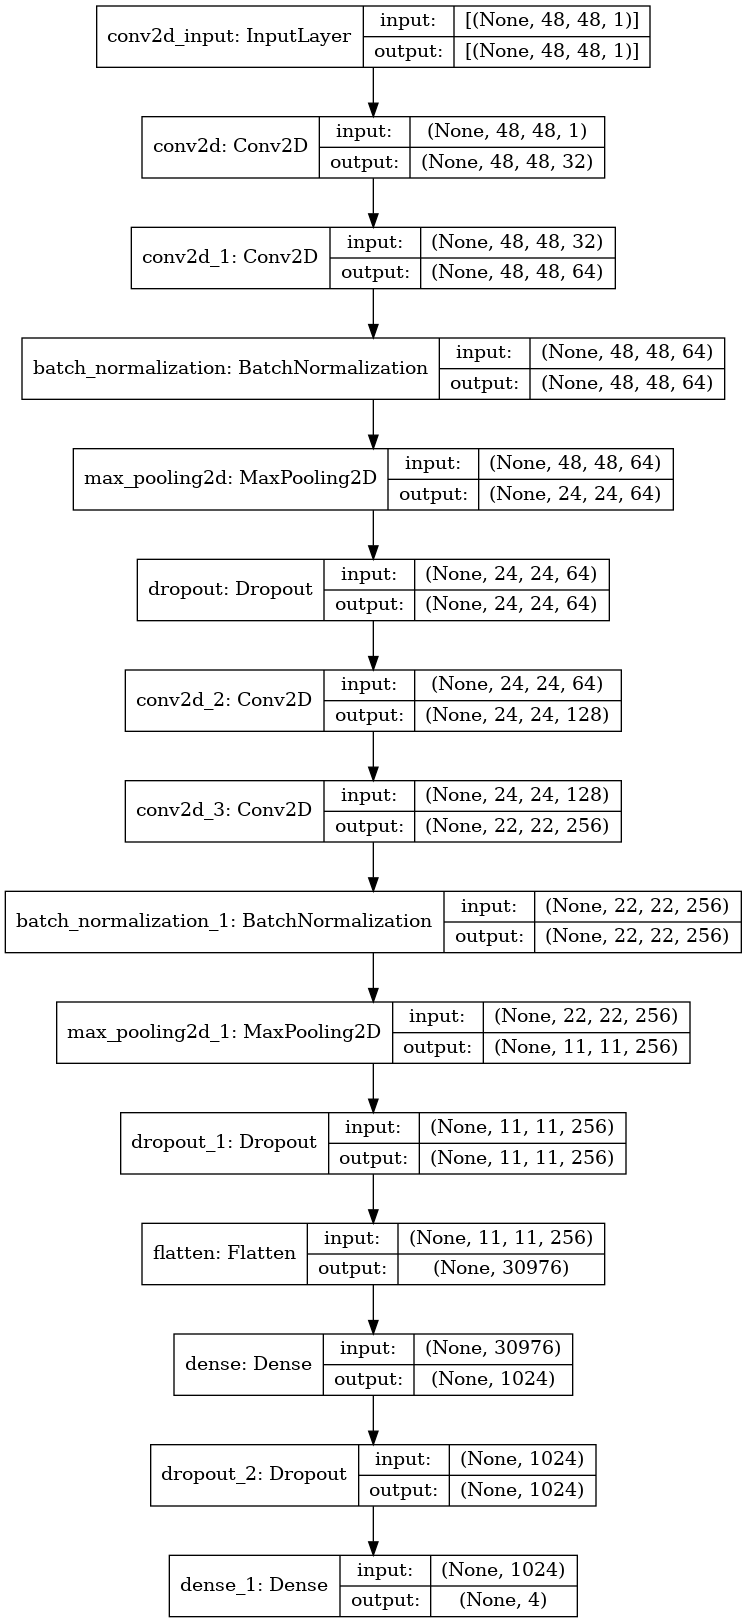

In [10]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

2022-01-31 19:25:16.542652: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-31 19:25:16.542691: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-31 19:25:16.545034: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-31 19:25:16.758308: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-31 19:25:16.758478: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

2022-01-31 19:25:17.179992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-01-31 19:25:18.765335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


328/328 [==============================] - 75s 207ms/step - loss: 3.9574 - accuracy: 0.3651 - val_loss: 10.9547 - val_accuracy: 0.2363

Epoch 00001: val_loss improved from inf to 10.95471, saving model to ferNet.h5
Epoch 2/60
328/328 [==============================] - 26s 79ms/step - loss: 3.2131 - accuracy: 0.4179 - val_loss: 3.5429 - val_accuracy: 0.4414

Epoch 00002: val_loss improved from 10.95471 to 3.54290, saving model to ferNet.h5
Epoch 3/60
328/328 [==============================] - 26s 79ms/step - loss: 2.7786 - accuracy: 0.4538 - val_loss: 2.6067 - val_accuracy: 0.4882

Epoch 00003: val_loss improved from 3.54290 to 2.60674, saving model to ferNet.h5
Epoch 4/60
328/328 [==============================] - 27s 81ms/step - loss: 2.4188 - accuracy: 0.4768 - val_loss: 2.2321 - val_accuracy: 0.5073

Epoch 00004: val_loss improved from 2.60674 to 2.23209, saving model to ferNet.h5
Epoch 5/60
328/328 [==============================] - 28s 85ms/step - loss: 2.1139 - accuracy: 0.5027 -

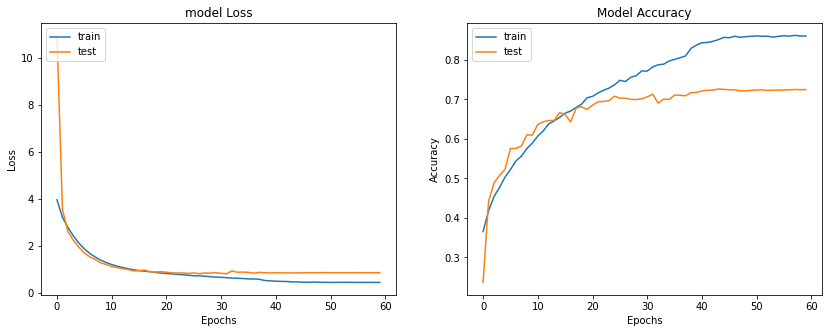

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

82/82 [==============================] - 3s 40ms/step - loss: 0.8538 - accuracy: 0.7245
final train accuracy = 91.65 , validation accuracy = 72.45


In [15]:
fernet.save("/kaggle/working/modelwith91accu.h5")

Confusion Matrix and Classification on training set

Confusion Matrix
[[ 734 1420  962  879]
 [1286 2473 1767 1689]
 [ 912 1720 1212 1121]
 [ 862 1674 1174 1120]]
Classification Report
              precision    recall  f1-score   support

       angry       0.19      0.18      0.19      3995
       happy       0.34      0.34      0.34      7215
     neutral       0.24      0.24      0.24      4965
         sad       0.23      0.23      0.23      4830

    accuracy                           0.26     21005
   macro avg       0.25      0.25      0.25     21005
weighted avg       0.26      0.26      0.26     21005



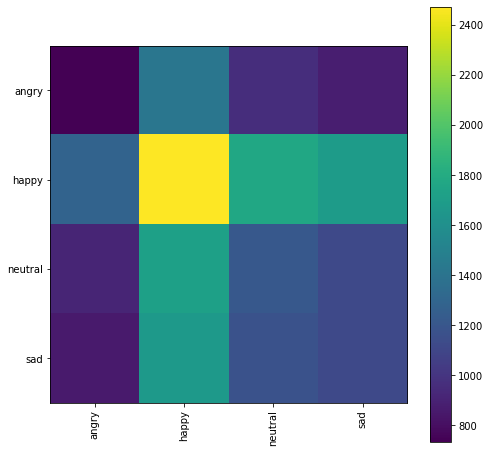

In [16]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

Confusion Matrix
[[188 316 228 226]
 [320 634 451 369]
 [225 394 333 281]
 [219 446 318 264]]
Classification Report
              precision    recall  f1-score   support

       angry       0.20      0.20      0.20       958
       happy       0.35      0.36      0.36      1774
     neutral       0.25      0.27      0.26      1233
         sad       0.23      0.21      0.22      1247

    accuracy                           0.27      5212
   macro avg       0.26      0.26      0.26      5212
weighted avg       0.27      0.27      0.27      5212



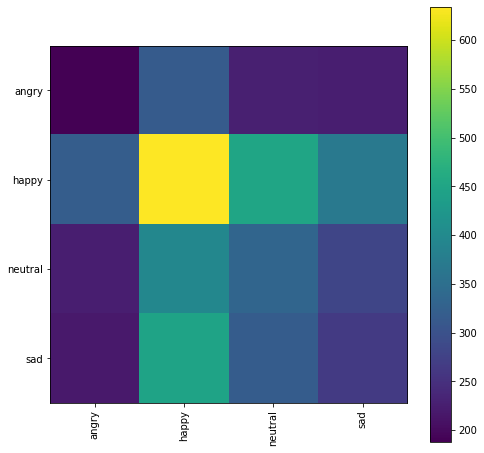

In [17]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [18]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 573 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 14.8 MB 1.0 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77056 sha256=555c29be032b1a7ab84a0dbb90f6225fedd6d632e6c47db99c2bbe8f22d0a6da
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: wrap

In [19]:
fer_json = fernet.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
fernet.save_weights("fer.h5")